C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures\Z: Found 100 text files


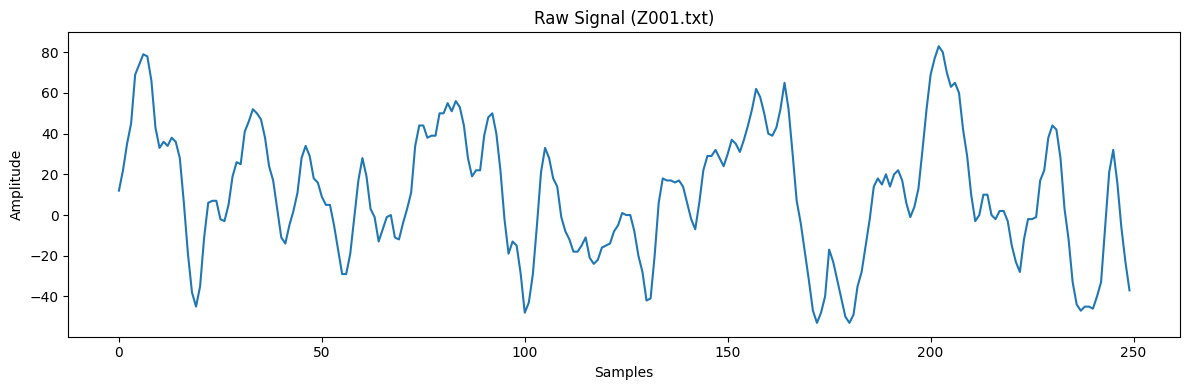

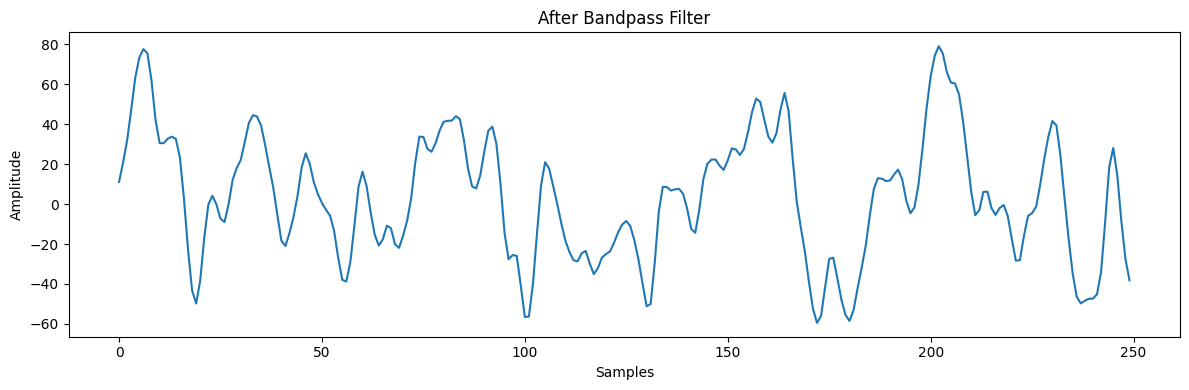

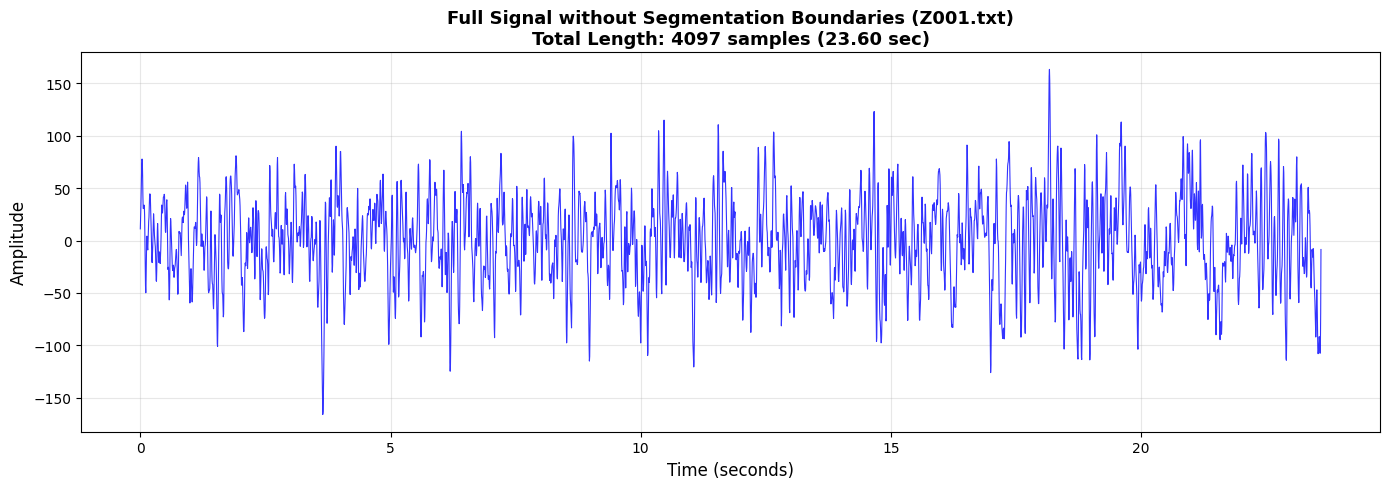

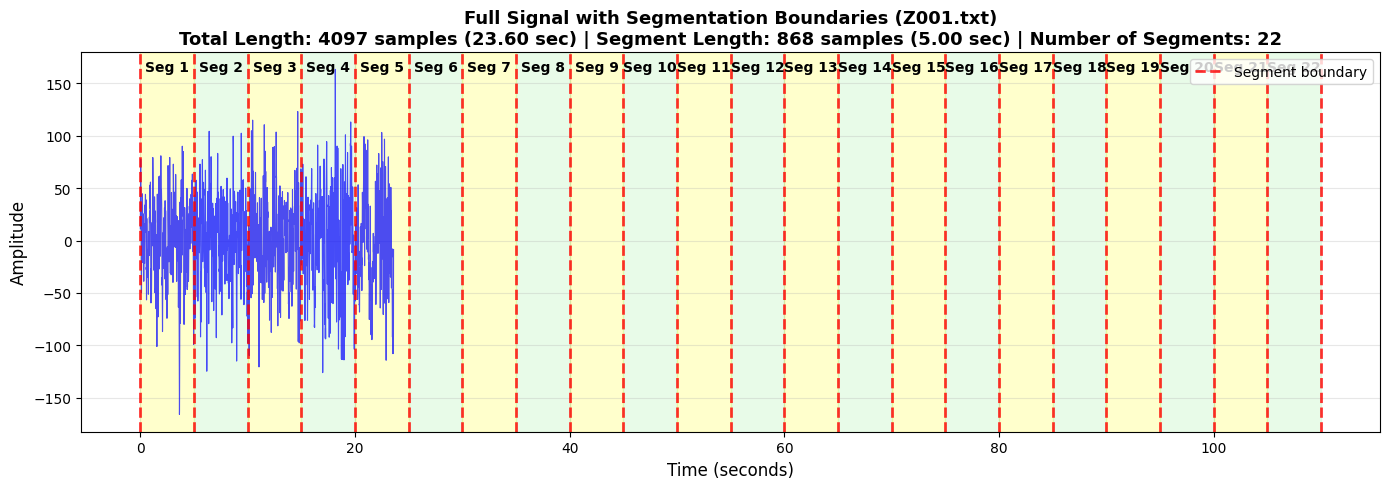

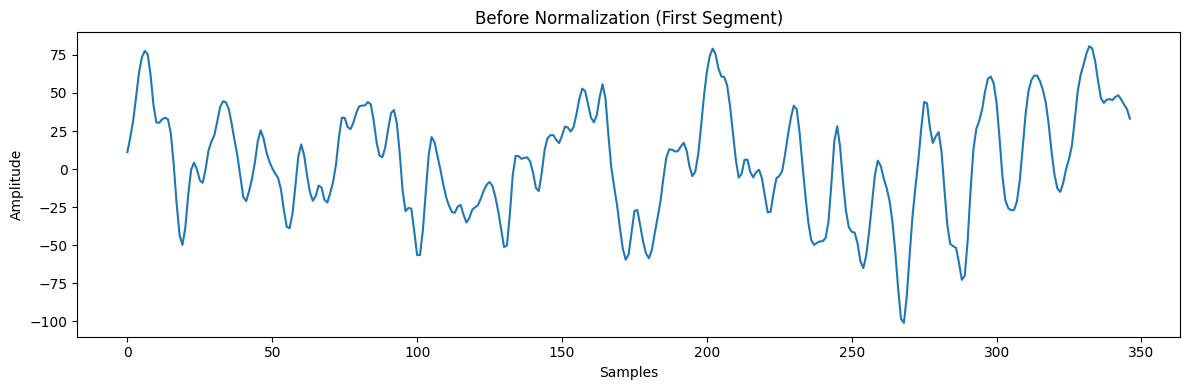

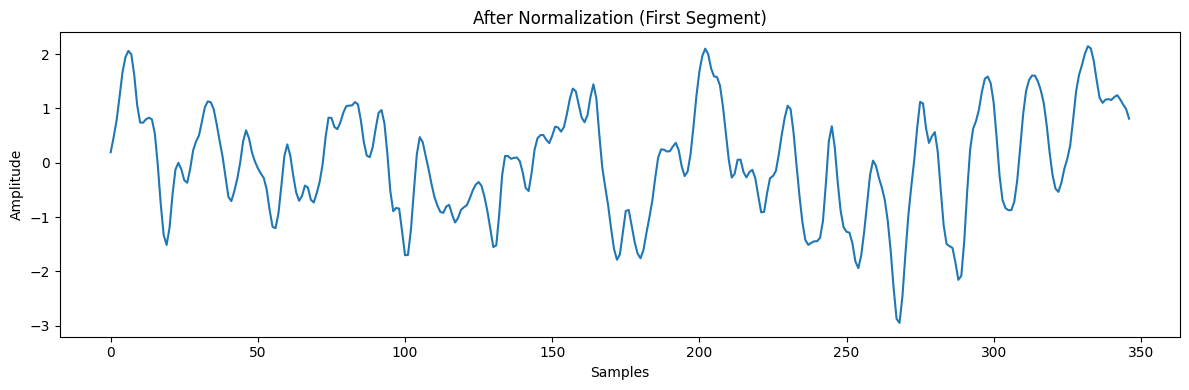

Saved NORMAL → (2200, 347) to NPY & TXT
C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures\O: Found 100 text files
Saved NORMAL → (2200, 347) to NPY & TXT
C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures\N: Found 100 text files
Saved INTERICTAL → (2200, 347) to NPY & TXT
C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures\F: Found 100 text files
Saved INTERICTAL → (2200, 347) to NPY & TXT
C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures\S: Found 100 text files
Saved ICTAL → (2200, 347) to NPY & TXT
All data merged and saved → X: (11000, 347), y: (11000,), file_ids: (11000,)
Total unique files: 500
Preprocessing complete!


In [5]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
from scipy.io import savemat

# Bandpass Filter

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=173.61, order=5):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Preprocessing Function

def preprocess_signal(signal, fs=173.61, segment_length=None):
    # Bandpass Filter
    filtered = bandpass_filter(signal, 0.5, 50, fs)

    # Segmentation WITH OVERLAP
    if segment_length is None:
        segment_length = int(2 * fs)  # 5-second segments = 868 samples
    
    step_size = int(segment_length * (1 - 0.5))  # 50% overlap = 434 samples
    
    segments = []
    for start in range(0, len(filtered) - segment_length + 1, step_size):
        end = start + segment_length
        segments.append(filtered[start:end])
    
    segments = np.array(segments)

    # Z-score normalization (per segment)
    normed_segments = np.zeros_like(segments)
    for i in range(segments.shape[0]):
        mean = segments[i].mean()
        std = segments[i].std()
        if std > 0:  # Avoid division by zero
            normed_segments[i] = (segments[i] - mean) / std
        else:
            normed_segments[i] = segments[i] - mean  # Just center if std=0

    return normed_segments, filtered, segments


def plot_segmentation_detailed(filtered, segments, fs=173.61, segment_length=None, filename=""):
   
    if segment_length is None:
        segment_length = int(5 * fs)
    
    num_segments = len(segments)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # Plot the full filtered signal
    time = np.arange(len(filtered)) / fs
    ax.plot(time, filtered, 'b-', linewidth=0.8, alpha=0.7)
    
    # Add vertical lines to show segment boundaries
    for i in range(num_segments + 1):
        segment_time = i * segment_length / fs
        ax.axvline(x=segment_time, color='red', linestyle='--', 
                   linewidth=2, alpha=0.8, label='Segment boundary' if i == 0 else '')
    
    # Shade different segments with alternating colors
    for i in range(num_segments):
        start_time = i * segment_length / fs
        end_time = (i + 1) * segment_length / fs
        color = 'yellow' if i % 2 == 0 else 'lightgreen'
        ax.axvspan(start_time, end_time, alpha=0.2, color=color)
        # Add segment labels
        mid_time = (start_time + end_time) / 2
        ax.text(mid_time, ax.get_ylim()[1] * 0.9, f'Seg {i+1}', 
                ha='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    
    title = f'Full Signal with Segmentation Boundaries'
    if filename:
        title += f' ({filename})'
    title += f'\nTotal Length: {len(filtered)} samples ({len(filtered)/fs:.2f} sec) | '
    title += f'Segment Length: {segment_length} samples ({segment_length/fs:.2f} sec) | '
    title += f'Number of Segments: {num_segments}'
    
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Load & Preprocess Dataset with File ID Tracking

def load_and_preprocess_bonn(root_dir, save_dir, plot_example=True):
    # Map folders to classes
    classes = {
        "Z": "NORMAL",
        "O": "NORMAL",
        "N": "INTERICTAL",
        "F": "INTERICTAL",
        "S": "ICTAL"
    }

    all_segments, all_labels, all_file_ids = [], [], []
    plotted = False
    global_file_id = 0  # Unique ID for each file

    for folder, label in classes.items():
        folder_path = os.path.join(root_dir, folder)
        files = glob.glob(os.path.join(folder_path, "**", "*.txt"), recursive=True)

        print(f"{folder_path}: Found {len(files)} text files")

        class_segments = []
        class_file_ids = []
        
        for i, file in enumerate(files):
            try:
                data = np.loadtxt(file)
                normed_segments, filtered, segments = preprocess_signal(data)

                # Plot one example
                if plot_example and not plotted:
                    # 1. Raw Signal
                    plt.figure(figsize=(12, 4))
                    plt.plot(data[:250])
                    plt.title(f"Raw Signal ({os.path.basename(file)})")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()

                    # 2. After Bandpass Filter (first 250 samples)
                    plt.figure(figsize=(12, 4))
                    plt.plot(filtered[:250])
                    plt.title("After Bandpass Filter")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()

                    # 3. Full Filtered Signal BEFORE Segmentation (NEW)
                    plt.figure(figsize=(14, 5))
                    time_full = np.arange(len(filtered)) / 173.61
                    plt.plot(time_full, filtered, 'b-', linewidth=0.8, alpha=0.8)
                    plt.xlabel('Time (seconds)', fontsize=12)
                    plt.ylabel('Amplitude', fontsize=12)
                    plt.title(f'Full Signal without Segmentation Boundaries ({os.path.basename(file)})\n' +
                             f'Total Length: {len(filtered)} samples ({len(filtered)/173.61:.2f} sec)',
                             fontsize=13, fontweight='bold')
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()

                    # 4. Detailed Segmentation Visualization AFTER Segmentation
                    plot_segmentation_detailed(filtered, segments, 
                                             fs=173.61, 
                                             segment_length=int(5*173.61),
                                             filename=os.path.basename(file))

                    plt.figure(figsize=(12, 4))
                    plt.plot(segments[0])
                    plt.title("Before Normalization (First Segment)")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()
                    
                    # 5. After Normalization (First Segment)
                    plt.figure(figsize=(12, 4))
                    plt.plot(normed_segments[0])
                    plt.title("After Normalization (First Segment)")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()
                    
                    plotted = True

                # ✅ KEY FIX: Assign same file_id to ALL segments from this file
                file_ids = np.full(len(normed_segments), global_file_id)
                
                class_segments.append(normed_segments)
                class_file_ids.append(file_ids)
                
                global_file_id += 1  # Increment for next file
                
            except Exception as e:
                print(f"Error reading {file}: {e}")

        if not class_segments:
            print(f"No valid data found for {folder}")
            continue

        class_segments = np.vstack(class_segments)
        class_file_ids = np.concatenate(class_file_ids)
        labels = np.full(len(class_segments), label)
        
        all_segments.append(class_segments)
        all_labels.append(labels)
        all_file_ids.append(class_file_ids)

        # --- Save per class ---
        os.makedirs(save_dir, exist_ok=True)

        np.save(os.path.join(save_dir, f"{label}_X.npy"), class_segments)
        np.save(os.path.join(save_dir, f"{label}_y.npy"), labels)
        np.save(os.path.join(save_dir, f"{label}_file_ids.npy"), class_file_ids)  # ✅ Save file IDs
        np.savetxt(os.path.join(save_dir, f"{label}_X.txt"), class_segments, fmt="%.6f")
        np.savetxt(os.path.join(save_dir, f"{label}_y.txt"), labels, fmt="%s")

        print(f"Saved {label} → {class_segments.shape} to NPY & TXT")

    # --- Merge all ---
    if not all_segments:
        raise RuntimeError("❌ No valid data loaded! Check folder paths or file format.")

    X = np.vstack(all_segments)
    y = np.concatenate(all_labels)
    file_ids = np.concatenate(all_file_ids)  # ✅ Merge file IDs

    np.save(os.path.join(save_dir, "ALL_X.npy"), X)
    np.save(os.path.join(save_dir, "ALL_y.npy"), y)
    np.save(os.path.join(save_dir, "ALL_file_ids.npy"), file_ids)  # ✅ Save file IDs
    np.savetxt(os.path.join(save_dir, "ALL_X.txt"), X, fmt="%.6f")
    np.savetxt(os.path.join(save_dir, "ALL_y.txt"), y, fmt="%s")

    print(f"All data merged and saved → X: {X.shape}, y: {y.shape}, file_ids: {file_ids.shape}")
    print(f"Total unique files: {len(np.unique(file_ids))}")

    return X, y, file_ids

# Main
if __name__ == "__main__":
    root = r"C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures"  # Path containing Z, O, N, F, S folders
    save_dir = os.path.join(root, "preprocessed")

    X, y, file_ids = load_and_preprocess_bonn(root, save_dir, plot_example=True)
    print("Preprocessing complete!")